# Import Library

In [ ]:
from torchvision.datasets import MNIST
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms,models
import numpy as np
from torch import nn
from tqdm import trange
import torch.nn.functional as F
import random
from lightly.loss import NTXentLoss



In [ ]:
!python -m pip install lightly

  Using cached lightly-1.5.22-py3-none-any.whl.metadata (38 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached lightly_utils-0.0.2-py3-none-any.whl.metadata (1.4 kB)
  Using cached pytorch_lightning-2.5.2-py3-none-any.whl.metadata (21 kB)
  Using cached aenum-3.1.16-py3-none-any.whl.metadata (3.8 kB)
  Using cached torchmetrics-1.8.0-py3-none-any.whl.metadata (21 kB)
  Using cached lightning_utilities-0.15.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu

# Data Preprocess

In [ ]:



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5]),
    transforms.Resize((27,27))
    ])



train_data=MNIST(train=True,download=True,root='./data',transform=transform)
test_data=MNIST(train=False,download=True,root='./data',transform=transform)

train_loader=DataLoader(train_data,batch_size=8,shuffle=True)
test_loader=DataLoader(test_data,batch_size=8,shuffle=True)

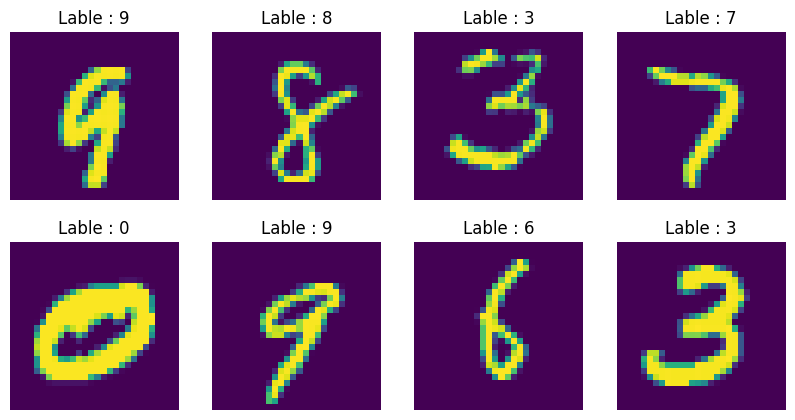

In [ ]:
fig,axs=plt.subplots(2,4,figsize=(10,5))
axs = axs.flatten()
imgs,lable=next(iter(train_loader))
for i in range(8):
  axs[i].imshow(imgs[i].squeeze())
  axs[i].set_title(f'Lable : {str(lable[i].item())}')
  axs[i].axis('off')

Text(0.5, 1.0, 'PCA')

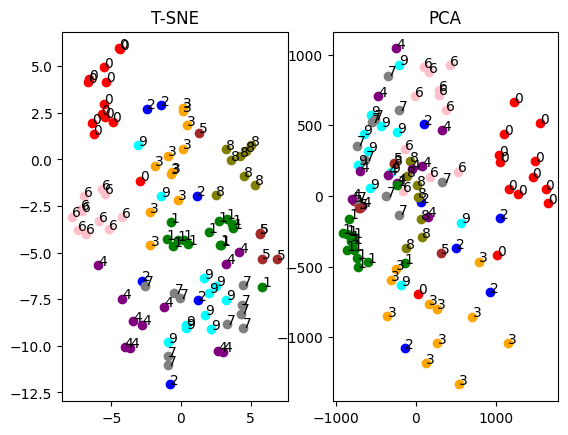

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np


tsne=TSNE(n_components=2)
pca=PCA(n_components=2)

tsne_results=tsne.fit_transform(train_data.data[:100].reshape(100,-1).numpy())
tsne_label=np.array(train_data.targets[:100])

pca_results=pca.fit_transform(train_data.data[:100].reshape(100,-1).numpy())

colors = [
    'red',
    'green',
    'blue',
    'orange',
    'purple',
    'brown',
    'pink',
    'gray',
    'olive',
    'cyan'
]


fig,axs=plt.subplots(1,2)


for i in range(100):


  axs[0].scatter(tsne_results[i,0],tsne_results[i,1],c=colors[tsne_label[i]])

  axs[0].text(tsne_results[i,0],tsne_results[i,1],tsne_label[i])

axs[0].set_title('T-SNE')

for i in range(100):


  axs[1].scatter(pca_results[i,0],pca_results[i,1],c=colors[tsne_label[i]])

  axs[1].text(pca_results[i,0],pca_results[i,1],tsne_label[i])


axs[1].set_title('PCA')




In PCA, the numbers are very scattered and the data from each class are not clustered together. However, in t-SNE, the data has improved, but for digit 2, the data points are still very scattered, and the same goes for digit 5.

In [ ]:
num_class=np.zeros(10)
for i in train_data.targets.numpy():
  num_class[i] = num_class[i]+1

Text(0, 0.5, 'Numbers of each class')

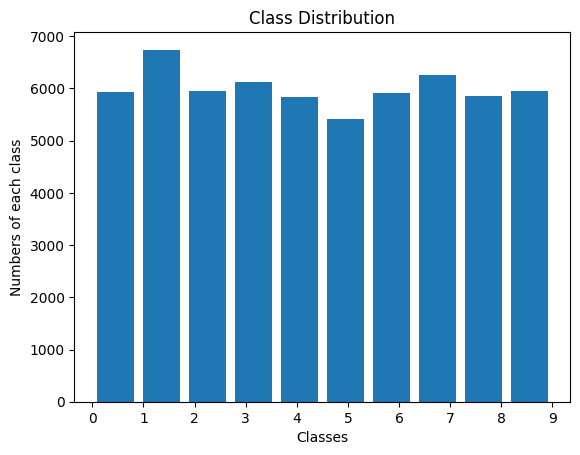

In [ ]:
plt.hist(train_data.targets,bins=10,rwidth=0.8)
plt.xticks(range(10))
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Numbers of each class')


And here, the goal was to show the distribution of the classes in the dataset.Which is very uniform; the distribution of the classes has no problem.



















# Encoder-Decoder

In [ ]:
class encoder_decoder(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder=nn.Sequential(
        nn.Conv2d(1,6,kernel_size=3,padding=2),
        nn.ReLU(),
        nn.Conv2d(6,12,kernel_size=3,stride=2),
        nn.ReLU(),
        nn.Conv2d(12,18,kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(18,24,kernel_size=2)
    )

    self.decoder=nn.Sequential(
        nn.ConvTranspose2d(24,18,kernel_size=2),
        nn.ReLU(),
        nn.ConvTranspose2d(18,12,kernel_size=2),
        nn.ReLU(),
        nn.ConvTranspose2d(12,6,kernel_size=3,stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(6,1,kernel_size=3,padding=2)


    )
  def forward(self,x):
      encode=self.encoder(x)
      decode=self.decoder(encode)
      return decode



In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
losses_en_de=[]
en_de_model=encoder_decoder()
en_de_model.to(device)
optimizer = torch.optim.Adam(en_de_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

en_de_model.train()
for i in trange(15):
  total_loss = 0.0
  for img,lbl in train_loader:
    img,lbl=img.to(device),lbl.to(device)
    optimizer.zero_grad()
    predict=en_de_model(img)

    loss = criterion(img,predict)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  avg_loss = total_loss / len(train_loader)
  losses_en_de.append(avg_loss)




100%|██████████| 15/15 [10:20<00:00, 41.34s/it]


I did not use labels in this network; an image is input to the network, and the output is compared with the original image to compute the loss.

In [ ]:
torch.save(en_de_model.state_dict(), 'de_en_model.pth')


In [ ]:
from google.colab import files
files.download('de_en_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

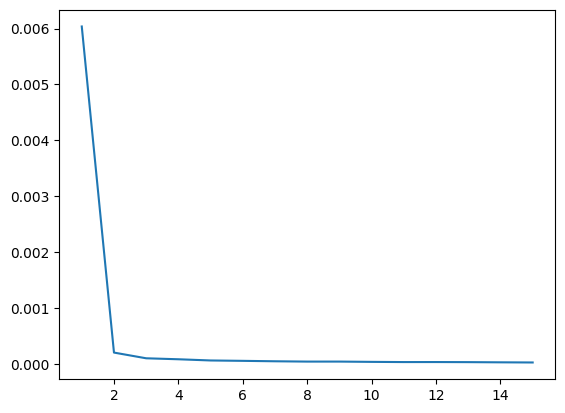

In [ ]:
plt.plot(range(1,16),losses_en_de)

The loss has decreased well and it's not noisy, so this training is reliable. The fluctuations in the encoder-decoder are not significant, and the number of epochs is also high, so the chance of overfitting is very low. Also, the test data makes this assumption more reliable.

In [ ]:
en_de_model=encoder_decoder()
en_de_model.load_state_dict(torch.load('/content/de_en_model.pth',map_location=device))
only_encoder=en_de_model.encoder

The model we previously downloaded — we can re-upload its weights onto the model.











In [ ]:
class classfc_en_de(nn.Module):
  def __init__(self,num_classes=10):
    super().__init__()
    self.encoder=only_encoder
    self.flatten=nn.Flatten()

    self.mlp=nn.Sequential(
        nn.Linear(24*12*12,2048),
        nn.ReLU(),
        nn.Linear(2048,1024),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(512,64),
        nn.ReLU(),
        nn.Linear(64,num_classes)

    )

  def forward(self,x):
    x=self.encoder(x)
    x=self.flatten(x)
    x=self.mlp(x)
    return x

In this setup, we only take the encoder part, and then we add a dense layer or an MLP after the encoder , but encoder is trainable

In [ ]:
from torch.utils.data import Subset
subset_2000 = Subset(train_data, list(range(500)))
limited_loader_train = DataLoader(subset_2000, batch_size=8, shuffle=True)


This dataset is a part of the training set, used for training and fine-tuning the classification network based on the encoder-decoder.









In [ ]:
losses_de_en=[]
classes_right = np.zeros(10)
classes_total = np.zeros(10)
classfc_en_de_model=classfc_en_de()
classfc_en_de_model.to(device)
optimizer = torch.optim.Adam(classfc_en_de_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

classfc_en_de_model.train()
for i in trange(15):
  total_loss = 0.0
  for img,lbl in limited_loader_train:
    img,lbl=img.to(device),lbl.to(device)
    optimizer.zero_grad()
    predict=classfc_en_de_model(img)

    loss = criterion(predict,lbl)
    loss.backward()
    optimizer.step()

    if i ==14:
      predicted_class = torch.argmax(predict, dim=1)
      #this is for check lsbles in each batch
      for j in range(len(lbl)):
            true_label = lbl[j].item()
            pred_label = predicted_class[j].item()


            classes_total[true_label] += 1

            if true_label == pred_label:
                classes_right[true_label] += 1



    total_loss += loss.item()
  avg_loss = total_loss / len(train_loader)
  losses_de_en.append(avg_loss)



100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


That we measure the accuracy for each class only in the final epochs.










In [ ]:
#donload data
torch.save(classfc_en_de_model.state_dict(), 'classfc_en_de_model.pth')
from google.colab import files
files.download('classfc_en_de_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
classes_right/classes_total

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

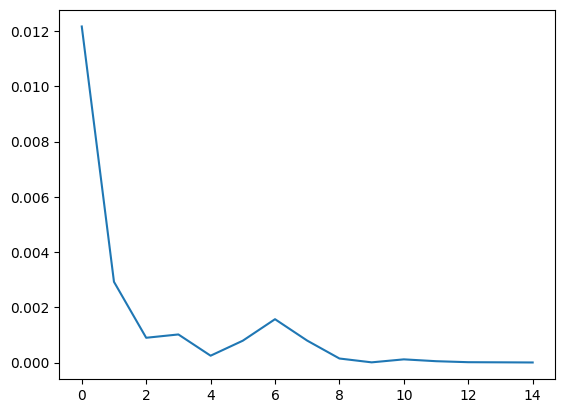

In [ ]:
plt.plot(range(15),losses_de_en)

The loss is low and the noise is minimal, overall the trend is decreasing and there is no significant problem observed.

In [ ]:
classfc_en_de_model.eval()
classes_right_test = np.zeros(10)
classes_total_test = np.zeros(10)

with torch.no_grad():
    for img, lbl in test_loader:
        img, lbl = img.to(device), lbl.to(device)
        predict = classfc_en_de_model(img)
        predicted_class = torch.argmax(predict, dim=1)

        for j in range(len(lbl)):
            true_label = lbl[j].item()
            pred_label = predicted_class[j].item()


            classes_total_test[true_label] += 1

            if true_label == pred_label:
                classes_right_test[true_label] += 1



Text(0, 0.5, 'Accuracy per Class')

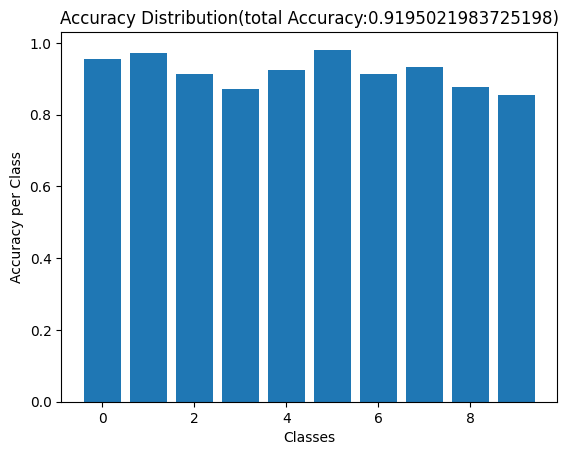

In [ ]:
accuracy_per_class_test = classes_right_test / classes_total_test
plt.bar(range(10),accuracy_per_class_test)
plt.title(f"Accuracy Distribution(total Accuracy:{sum(accuracy_per_class_test)/10})")
plt.xlabel('Classes')
plt.ylabel('Accuracy per Class')

We are now testing the model on the test data, and the results are excellent. This proves that the network has not overfitted and has predicted all the classes well.And of course, classes 3 and 9 performed slightly worse than the others — possibly due to the visual similarity between these two digits.

#Rotation method

In [ ]:
class rotate_dataset(Dataset):
  def __init__(self,data):
    self.img=data.data
    self.target=data.targets

  def __len__(self):
    return len(self.img)


  def __getitem__(self,idx):

    angles=[0,30,45,90,180,270]
    weights = [0.17, 0.17, 0.17, 0.15, 0.17, 0.17]
    random_index = random.choices(range(len(angles)), weights=weights, k=1)[0]

    img_pil = transforms .ToPILImage()(self.img[idx])
    img_rotate=transforms.ToTensor()(transforms.functional.rotate(img_pil, angles[random_index]))


    return img_rotate,random_index,angles[random_index]






ChatGPT said:
Because I wanted the dataset to have an equal amount of data from every angle, and also to be random, I selected weights that were close to each other.

In [ ]:
rotate_train_data=rotate_dataset(train_data)

In [ ]:
rotate_train_loader=DataLoader(rotate_train_data,batch_size=8,shuffle=True)

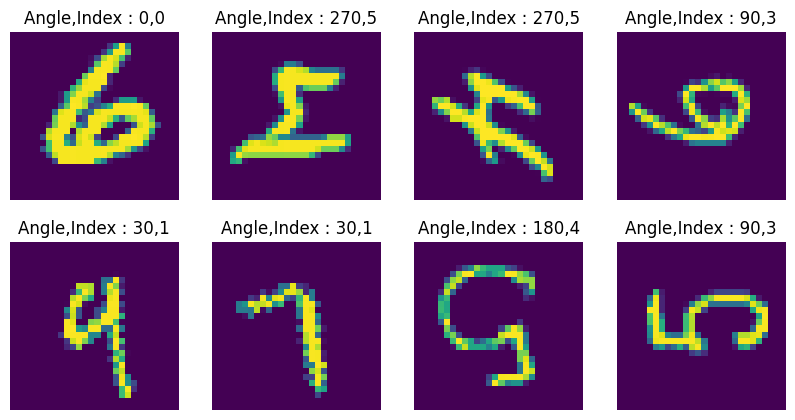

In [ ]:
fig,axs=plt.subplots(2,4,figsize=(10,5))
axs = axs.flatten()
imgs,idx,lable=next(iter(rotate_train_loader))
for i in range(8):
  axs[i].imshow(imgs[i].squeeze())
  axs[i].set_title(f'Angle,Index : {str(lable[i].item())},{str(idx[i].item())}')
  axs[i].axis('off')

In [ ]:
ditribution_angle=[]
for img,idx,angle in rotate_train_data:

  ditribution_angle.append(angle)



Counter({270: 10409, 0: 10193, 45: 10175, 30: 10172, 180: 10078, 90: 8973})


In [ ]:
class rotate_classification(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder=nn.Sequential(
        nn.Conv2d(1,6,kernel_size=3,padding=2),
        nn.ReLU(),
        nn.Conv2d(6,12,kernel_size=3,stride=2),
        nn.ReLU(),
        nn.Conv2d(12,18,kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(18,24,kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(24,30,kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(30,36,kernel_size=2)

    )

    self.flatten=nn.Flatten()

    self.mlp=nn.Sequential(
        nn.Linear(36*10*10,2048),
        nn.Linear(2048,1024),
        nn.Linear(1024,512),
        nn.Linear(512,218),
        nn.Linear(218,6)
    )


  def forward(self,x):
    x=self.encoder(x)

    x=self.flatten(x)
    x=self.mlp(x)
    return x



In [ ]:
rotate_classification_model=rotate_classification()
torch.save(rotate_classification_model.state_dict(), '/content/rotate_classification_model.pth')



In [ ]:
#rotate_classification_model=rotate_classification()
#rotate_classification_model.load_state_dict(torch.load('/content/rotate_classification_model.pth',map_location=device))



In [ ]:
losses_rotate=[]
classes_right = np.zeros(6)
classes_total = np.zeros(6)
rotate_classification_model=rotate_classification()
rotate_classification_model.to(device)
optimizer = torch.optim.Adam(rotate_classification_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

rotate_classification_model.train()
for i in trange(15):
  total_loss = 0.0
  for img,lbl,angle in rotate_train_loader:
    img,lbl=img.to(device),lbl.to(device)
    optimizer.zero_grad()
    predict=rotate_classification_model(img)

    loss = criterion(predict,lbl)
    loss.backward()
    optimizer.step()

    if i ==14:
      predicted_class = torch.argmax(predict, dim=1)
      for j in range(len(lbl)):
            true_label = lbl[j].item()
            pred_label = predicted_class[j].item()


            classes_total[true_label] += 1

            if true_label == pred_label:
                classes_right[true_label] += 1



    total_loss += loss.item()
  avg_loss = total_loss / len(train_loader)
  losses_rotate.append(avg_loss)

100%|██████████| 15/15 [15:23<00:00, 61.54s/it]


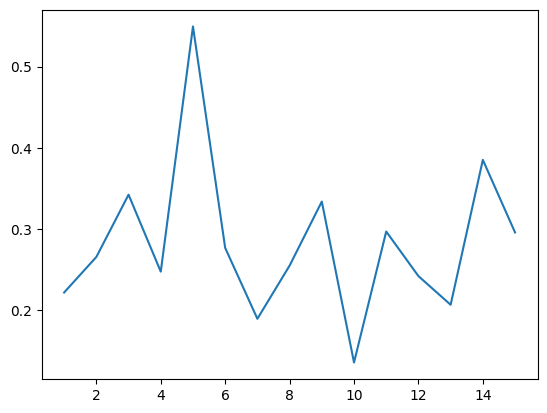

In [ ]:
plt.plot(range(1,16),losses_rotate)

This loss is very noisy and not reliable, and there is a high chance of overfitting. By increasing the number of epochs and deepening the network, it may be possible to achieve a better loss.

In [ ]:
torch.save(rotate_classification_model.state_dict(), 'rotate_classification_model.pth')
from google.colab import files
files.download('rotate_classification_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rotate_classification()

rotate_classification(
  (encoder): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(12, 18, kernel_size=(2, 2), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(18, 24, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(24, 30, kernel_size=(2, 2), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(30, 36, kernel_size=(2, 2), stride=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=3600, out_features=2048, bias=True)
    (1): Linear(in_features=2048, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=218, bias=True)
    (4): Linear(in_features=218, out_features=6, bias=True)
  )
)

In [ ]:
only_encoder_rotate=rotate_classification_model.encoder

In [ ]:
class classfc_by_rotate(nn.Module):
  def __init__(self,num_classes=10):
    super().__init__()
    self.encoder=only_encoder_rotate
    self.flatten=nn.Flatten()

    self.mlp=nn.Sequential(
        nn.Linear(36*10*10,2048),
        nn.ReLU(),
        nn.Linear(2048,1024),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(512,64),
        nn.ReLU(),
        nn.Linear(64,num_classes)

    )

  def forward(self,x):
    x=self.encoder(x)
    x=self.flatten(x)
    x=self.mlp(x)
    return x

In [ ]:
losses_classfc_by_rotate_model=[]
classes_right = np.zeros(10)
classes_total = np.zeros(10)
classfc_by_rotate_model=classfc_by_rotate()
classfc_by_rotate_model.to(device)
optimizer = torch.optim.Adam(classfc_by_rotate_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

classfc_by_rotate_model.train()
for i in trange(15):
  total_loss = 0.0
  for img,lbl in limited_loader_train:
    img,lbl=img.to(device),lbl.to(device)
    optimizer.zero_grad()
    predict=classfc_by_rotate_model(img)

    loss = criterion(predict,lbl)
    loss.backward()
    optimizer.step()

    if i ==14:
      predicted_class = torch.argmax(predict, dim=1)
      for j in range(len(lbl)):
            true_label = lbl[j].item()
            pred_label = predicted_class[j].item()


            classes_total[true_label] += 1

            if true_label == pred_label:
                classes_right[true_label] += 1



    total_loss += loss.item()
  avg_loss = total_loss / len(train_loader)
  losses_classfc_by_rotate_model.append(avg_loss)

100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


And again, we take the encoder part from the rotate_classification model and place an MLP at the end, then train it to classify the original data.

Text(0, 0.5, 'Accuracy per Class')

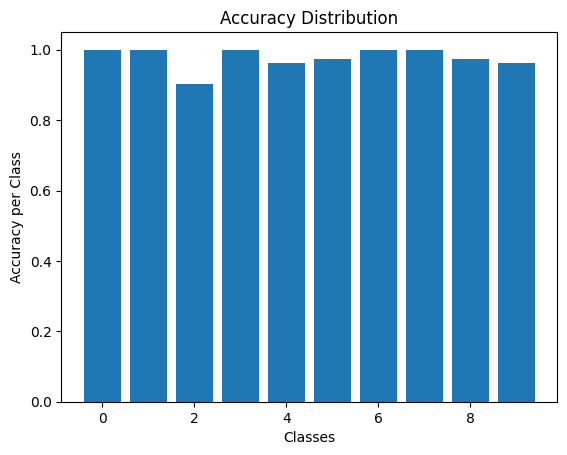

In [ ]:
accuracy_per_class = classes_right / classes_total
plt.bar(range(10),accuracy_per_class)
plt.title('Accuracy Distribution')
plt.xlabel('Classes')
plt.ylabel('Accuracy per Class')

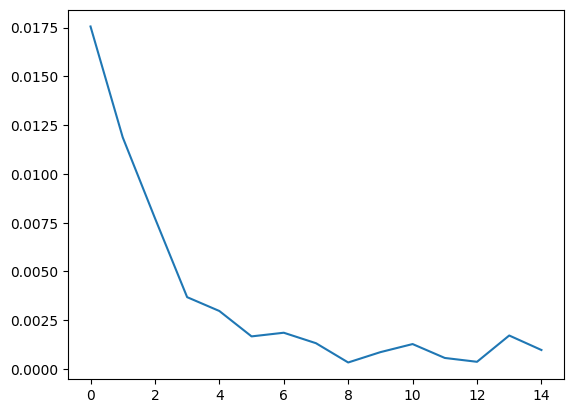

In [ ]:
plt.plot(range(15),losses_classfc_by_rotate_model)

The loss has decreased well and is very low-noise, which is not a big issue.












In [ ]:
classfc_by_rotate_model.eval()
classes_right_test = np.zeros(10)
classes_total_test = np.zeros(10)

with torch.no_grad():
    for img, lbl in test_loader:
        img, lbl = img.to(device), lbl.to(device)
        predict = classfc_by_rotate_model(img)
        predicted_class = torch.argmax(predict, dim=1)

        for j in range(len(lbl)):
            true_label = lbl[j].item()
            pred_label = predicted_class[j].item()


            classes_total_test[true_label] += 1

            if true_label == pred_label:
                classes_right_test[true_label] += 1

Text(0, 0.5, 'Accuracy per Class')

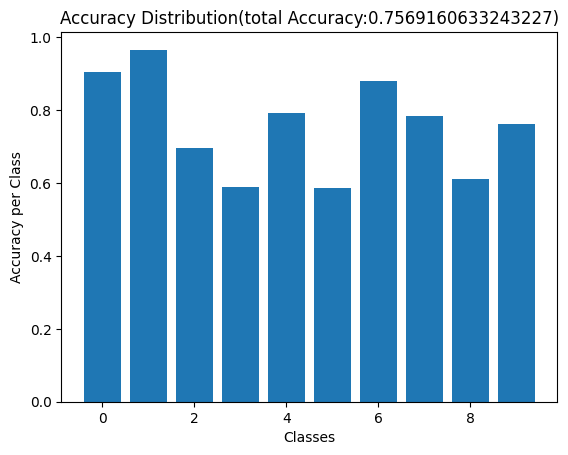

In [ ]:
accuracy_per_class_test = classes_right_test / classes_total_test
plt.bar(range(10),accuracy_per_class_test)
plt.title(f"Accuracy Distribution(total Accuracy:{sum(accuracy_per_class_test)/10})")
plt.xlabel('Classes')
plt.ylabel('Accuracy per Class')

The accuracy hasn't improved much, which was expected since the rotate_classification model hadn't decreased well either.

# SimCLR

In [ ]:
class simclrtranformer:
    def __init__(self):
        self.transform=transforms.Compose([
            transforms.RandomResizedCrop(size=32),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.5, 0.5, 0.5, 0.1),
            transforms.RandomGrayscale(p=0.2),

        ])

    def __call__(self,x):
        x_i,x_j=self.transform(x),self.transform(x)
        return x_i,x_j


class simclrdataset(Dataset):
    def __init__(self,dataset):
      # for Augmetation
        self.transformer=simclrtranformer()
        self.dataset=dataset

    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        x,_=self.dataset[index]
        xi,xj=self.transformer(x)
        return xi,xj


class simclrmodel(nn.Module):
    def __init__(self,projection_dim=128 ):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.projector = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )


    def forward(self,x):
        h=self.encoder(x)
        h = torch.flatten(h, start_dim=1)
        z=self.projector(h)
        return z


In [ ]:
dataset_simclr=simclrdataset(train_data)
train_loader_simclr=DataLoader(dataset_simclr,batch_size=8)

In [ ]:
simclr_model=simclrmodel()
simclr_model.load_state_dict(torch.load('/content/simclr_model.pth',map_location=device))

<All keys matched successfully>

In [ ]:
losses_simclr=[]
simclr_model=simclrmodel()
simclr_model.to(device)
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=1e-3)
#loss for SimCLR
criterion = criterion = NTXentLoss(temperature=0.5)



simclr_model.train()
for i in trange(15):
  total_loss = 0.0
  for img1,img2 in train_loader_simclr:
    img1,img2=img1.to(device),img2.to(device)
    optimizer.zero_grad()
    z1,z2=simclr_model(img1),simclr_model(img2)

    loss = criterion(z1,z2)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  avg_loss = total_loss / len(train_loader_simclr)
  losses_simclr.append(avg_loss)

100%|██████████| 15/15 [34:47<00:00, 139.14s/it]


Text(0, 0.5, 'Losses')

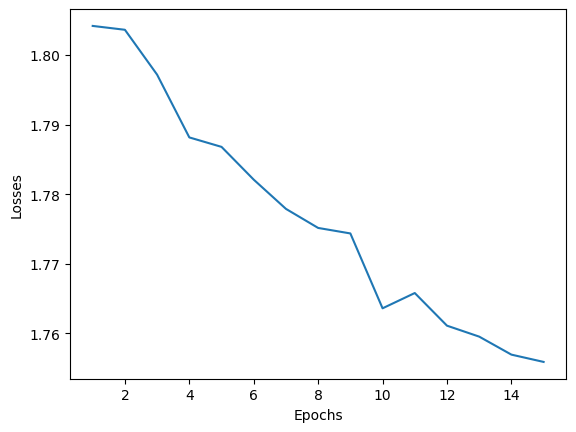

In [ ]:
plt.plot(range(1,16),losses_simclr)
plt.xlabel('Epochs')
plt.ylabel('Losses')

The loss has decreased correctly, but its value is not very good. However, it can be improved by increasing the number of epochs.

In [ ]:
torch.save(simclr_model.state_dict(), 'simclr_model.pth')
from google.colab import files
files.download('simclr_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class classfc_by_simclr(nn.Module):
  def __init__(self,num_classes=10):
    super().__init__()
    self.encoder=simclr_model

    self.mlp=nn.Sequential(
        nn.Linear(64,64),
        nn.Linear(64,32),
        nn.Linear(32,num_classes)



    )

  def forward(self,x):
    x=self.encoder(x)
    x=self.mlp(x)
    return x

In [ ]:
losses_classfc_by_simclr=[]
classes_right = np.zeros(10)
classes_total = np.zeros(10)
classfc_by_simclr_model=classfc_by_simclr()
classfc_by_simclr_model.to(device)
optimizer = torch.optim.Adam(classfc_by_simclr_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

classfc_by_simclr_model.train()
for i in trange(15):
  total_loss = 0.0
  for img,lbl in limited_loader_train:
    img,lbl=img.to(device),lbl.to(device)
    optimizer.zero_grad()
    predict=classfc_by_simclr_model(img)

    loss = criterion(predict,lbl)
    loss.backward()
    optimizer.step()

    if i ==14:
      predicted_class = torch.argmax(predict, dim=1)
      for j in range(len(lbl)):
            true_label = lbl[j].item()
            pred_label = predicted_class[j].item()


            classes_total[true_label] += 1

            if true_label == pred_label:
                classes_right[true_label] += 1



    total_loss += loss.item()
  avg_loss = total_loss / len(train_loader)
  losses_classfc_by_simclr.append(avg_loss)

100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


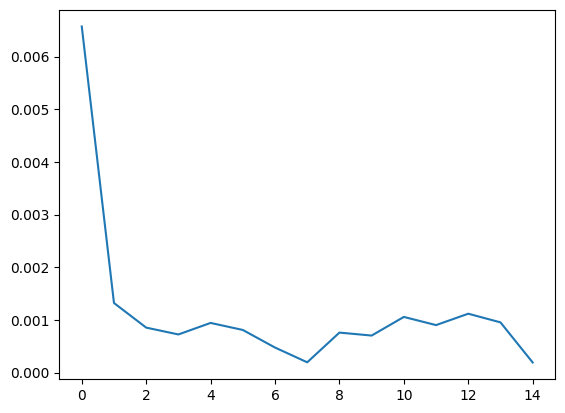

In [ ]:
plt.plot(range(15),losses_classfc_by_simclr)

LOSS ist Great!!!!!!

In [ ]:


classfc_by_simclr.eval()
classes_right_test = np.zeros(10)
classes_total_test = np.zeros(10)

with torch.no_grad():
    for img, lbl in test_loader:
        img, lbl = img.to(device), lbl.to(device)
        predict = classfc_by_simclr_model(img)
        predicted_class = torch.argmax(predict, dim=1)

        for j in range(len(lbl)):
            true_label = lbl[j].item()
            pred_label = predicted_class[j].item()


            classes_total_test[true_label] += 1

            if true_label == pred_label:
                classes_right_test[true_label] += 1

Text(0, 0.5, 'Accuracy per Class')

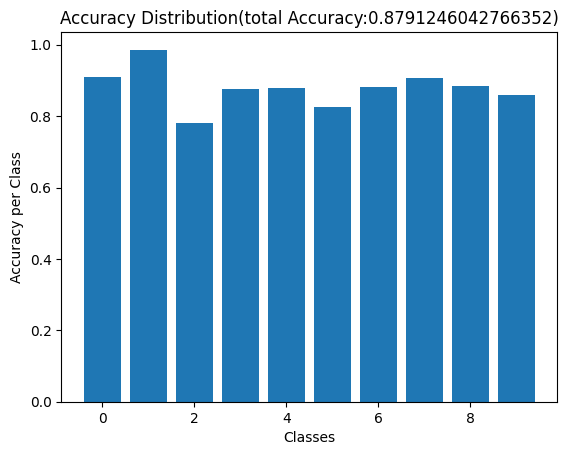

In [ ]:
accuracy_per_class_test = classes_right_test / classes_total_test
plt.bar(range(10),accuracy_per_class_test)
plt.title(f"Accuracy Distribution(total Accuracy:{sum(accuracy_per_class_test)/10})")
plt.xlabel('Classes')
plt.ylabel('Accuracy per Class')

Overall, if the dataset is simple and the number of classes is not very high, the encoder-decoder approach is recommended — because it's both easy to train and produces good output. Of course, you need to be careful about overfitting, since with a high number of epochs, the risk of overfitting in this type of network is high.

However, SimCLR has a lower risk of overfitting and is recommended for more complex datasets that require many epochs to train effectively
